# Using a pretrained image labeling model

In [1]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

In [2]:
# Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

model = resnet50(weights=weights)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
# Read in image
img = read_image('car23.jpg')

# Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

minivan: 14.0%


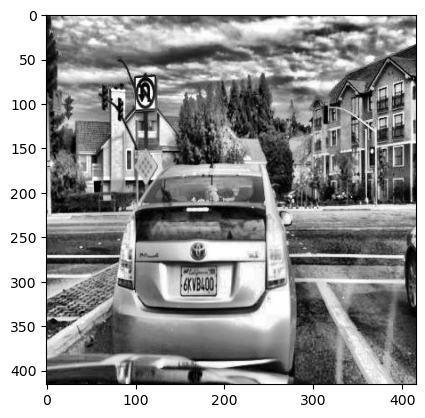

In [4]:
# Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

plt.imshow(to_pil_image(img))

# Using a pretrained object detection model

In [5]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes

img = read_image("cat.png")

# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

In [6]:
# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, 
                          font='arial',
                          font_size=30)
im = to_pil_image(box.detach())

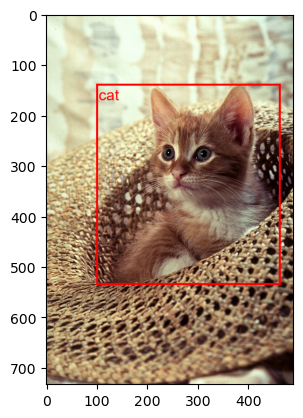

In [7]:
plt.imshow(im)

---

# Visualizing PyTorch object detection and true labels on my dataset

### Building a workflow for displaying true labels of a test image

In [8]:
dataset_path = '../dataset_small/test/'

# read in _annotations.csv file with bboxes and labels into ann_df
names = ['img_name', 'x1', 'y1', 'x2', 'y2', 'label']
ann_df = pd.read_csv(dataset_path + '_annotations.csv', header=None, names=names)
ann_df.head()

,img_name,x1,y1,x2,y2,label
0,img1.jpg,173,224,193,254,car
1,img64.jpg,81,202,109,220,car
2,img64.jpg,101,206,136,249,car
3,img64.jpg,101,207,131,245,car
4,img64.jpg,160,196,180,215,car


In [9]:
def get_true_labels(ann_df, img_name):
    '''
    get_true_labels: Filters ann_df to return bboxes and labels for the requested image.
    
    :param ann_df: pd.DataFrame, format --> ['img_name', 'x1', 'y1', 'x2', 'y2', 'label']
    :param img_name: string, name of the file itself from the test dataset, not the path
    
    returns labels, bboxes
    '''
    
    ann_subset_df = ann_df[ann_df['img_name'] == img_name]
    assert ann_subset_df.size > 0, 'Assert: No such file'
    
    bboxes_df = ann_subset_df[['x1', 'y1', 'x2', 'y2']]

    labels = list(ann_subset_df['label'])
    bboxes = torch.tensor(bboxes_df.to_numpy())
    
    return labels, bboxes

In [10]:
def draw_bboxes(img_name, labels, bboxes):
    '''
    draw_bboxes: Loads the image and draws bounding boxes using PyTorch read_image and
                 draw_bounding_boxes helper functions.
    
    :param img_name: string, name of the image to display, not the image path
    :param labels: list[str], list of labels for each bounding box in bboxes
    :param bboxes: torch.tensor([[num]]), list of lists of bounding boxes
                   format --> ['x1', 'y1', 'x2', 'y2']
    '''
    
    img = read_image(dataset_path + img_name)
    box = draw_bounding_boxes(img,
                              boxes=bboxes,
                              labels=labels,
                              colors="red",
                              width=3, 
                              font='arial',
                              font_size=30)
    im = to_pil_image(box.detach())
    plt.imshow(im)

In [11]:
def show_true_labels(img_num):
    '''
    show_true_labels: Display the requested image and it's true bounding boxes.
    
    :param img_num: The image number in the test dataset, 42 -> img42.jpg
    '''
    
    img_name = 'img{}.jpg'.format(img_num)
    labels, bboxes = get_true_labels(ann_df, img_name)
    draw_bboxes(img_name, labels, bboxes)

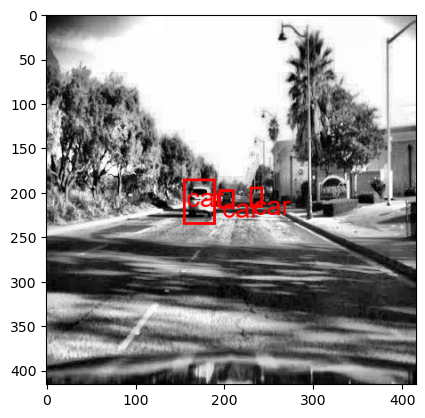

In [12]:
show_true_labels(img_num=42)

### Get predicted bounding boxes using FasterRCNN

In [13]:
# try running processing for FasterRCNN, then draw bounding boxes again
faster_rcnn_weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
faster_rcnn = fasterrcnn_resnet50_fpn_v2(weights=faster_rcnn_weights, box_score_thresh=0.9)
faster_rcnn.eval()

# Initialize the inference transforms
faster_rcnn_preprocess = faster_rcnn_weights.transforms()

In [14]:
def get_preds(model, img, preprocess):
    '''
    get_preds: Returns a list of predictions from running the model on the image.
    
    :param model: The object detection model
    :param img: The image of interest
    '''
    
    # Apply inference preprocessing transforms
    batch = [preprocess(img)]

    # Use the model and visualize the prediction
    predictions = model(batch)
    
    return predictions

In [15]:
def get_model_bboxes(prediction):
    '''
    get_model_bboxes: returns only the boxes and labels that are equal to the requested label
    
    :param prediction:
    :param car_label: The desired label to return bounding boxes for
    '''
    
    # my dataset is only concerned with labels for cars at the moment.
    # So we're only interested in one of the possible label enums.
    meta_cats = faster_rcnn_weights.meta["categories"]
    car_label = [int(i) for i in range(len(meta_cats)) if meta_cats[i] == 'car'][0]
    
    indeces = [i for i in range(len(prediction['labels'])) if prediction['labels'][i] == car_label]
    labels = prediction['labels'][indeces]
    bboxes = prediction['boxes'][indeces]
    
    return bboxes, ['car' for _ in labels]

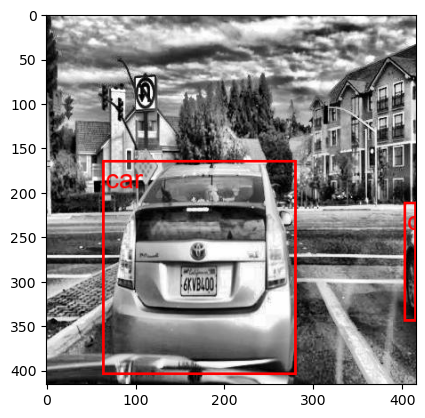

In [16]:
dataset_path = '../dataset_small/test/'

# set image
img_num = 23
img_name = 'img{}.jpg'.format(img_num)
img = read_image(dataset_path + img_name)

# get predictions from model
prediction = get_preds(faster_rcnn, img, preprocess=faster_rcnn_preprocess)[0]

# draw bounding boxes
bboxes, labels = get_model_bboxes(prediction)
draw_bboxes(img_name, labels, bboxes)

Now, comparing to true labels

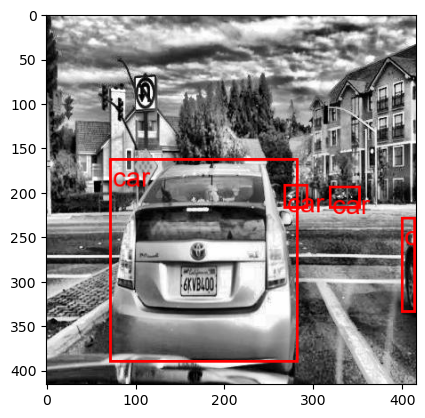

In [17]:
show_true_labels(img_num)

### Running mAP on a single image

Now that we've successfully visualized the bboxes for the true labels of an image, and the predicted labels of the same image, we should be able to run PyTorch's mean Average Precision metric on our model to see how it performs.

For now, we will assume a dataset of one image.

In [18]:
# TODO

### Running mAP on a batch of two images

Now we will run the same metric but on a dataset of two images.

In [19]:
# TODO